EfficientNet-b5:
* v1: 1st `fit_one_cycle(4, max_lr=5e-3)`, 2nd `fit_one_cycle(6, max_lr=1e-3)`
* v3: 1st `fit_one_cycle(4, max_lr=3e-3)`, 2nd `fit_one_cycle(10, max_lr=1e-4)`
* v4: 1st `fit_one_cycle(4, max_lr=3e-3)`, 2nd `fit_one_cycle(10, max_lr=1e-3)`
* v6: 1st `fit_one_cycle(4, max_lr=3e-3)`, 2nd `fit_one_cycle(15, max_lr=1e-3)`
* v7: 

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import os
os.listdir('../input')
import sys
import random
import json
from functools import partial
from collections import OrderedDict, Counter
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
from PIL import Image

from sklearn import metrics
from sklearn.metrics import cohen_kappa_score

import torch
import torch.nn as nn
from fastai import *
from fastai.vision import *
from fastai.vision import (cnn_learner, models, get_transforms, 
                           ImageList, FloatList, ResizeMethod, imagenet_stats,
                           ClassificationInterpretation)
from fastai.vision import Learner, DatasetType
print('Make sure cudnn is enabled:', torch.backends.cudnn.enabled)

Make sure cudnn is enabled: True


In [2]:
effnet_pac_path = '../input/efficientnet-pytorch/efficientnet-pytorch/EfficientNet-PyTorch-master'
sys.path.append(effnet_pac_path)
from efficientnet_pytorch import EfficientNet

In [3]:
# Making pretrained weights work without needing to find the default filename
if not os.path.exists('/tmp/.cache/torch/checkpoints/'):
        os.makedirs('/tmp/.cache/torch/checkpoints/')
# !cp '../input/resnet50/resnet50.pth' '/tmp/.cache/torch/checkpoints/resnet50-19c8e357.pth'

In [4]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

SEED = 2019  # 999
seed_everything(SEED)

In [5]:
base_image_dir = '../input/aptos2019-blindness-detection/'
train_dir = os.path.join(base_image_dir,'train_images/')
df = pd.read_csv(os.path.join(base_image_dir, 'train.csv'))
df['path'] = df['id_code'].map(lambda x: os.path.join(train_dir,'{}.png'.format(x)))
df = df.drop(columns=['id_code'])
df = df.sample(frac=1).reset_index(drop=True) #shuffle dataframe
print(df.shape)

(3662, 2)


In [6]:
bs = BATCH_SIZE = 32  # 64 # smaller batch size is better for training, but may take longer
sz = IMG_SIZE = 256

In [7]:
tfms = get_transforms(do_flip=True, flip_vert=True, max_rotate=360, max_warp=0, max_zoom=1.1, max_lighting=0.1, p_lighting=0.5)
src = (ImageList
    .from_df(df=df,path='./',cols='path') #get dataset from dataset
    .split_by_rand_pct(0.2) #Splitting the dataset
    .label_from_df(cols='diagnosis',label_cls=FloatList) #obtain labels from the level column
)
data= (src
    .transform(tfms, size=IMG_SIZE, resize_method=ResizeMethod.SQUISH, padding_mode='zeros') #Data augmentation
    .databunch(bs=BATCH_SIZE, num_workers=4) #DataBunch
    .normalize(imagenet_stats) #Normalize
)

## Training (Transfer learning)

In [8]:
def quadratic_kappa(y_hat, y):
    scores = cohen_kappa_score(torch.round(y_hat), y, weights='quadratic')
    return torch.tensor(scores, device='cuda:0')

In [9]:
def load_efficientnet(model_name='efficientnet-b7', model_path=None, pretrained=True):
    model = EfficientNet.from_name(model_name, override_params={'num_classes': 1})
    if not pretrained:
        return model
    
    model_state = torch.load(model_path)
    if '_fc.weight' in model_state.keys():
        model_state.pop('_fc.weight')
        model_state.pop('_fc.bias')
        res = model.load_state_dict(model_state, strict=False)
        assert str(res.missing_keys) == str(['_fc.weight', '_fc.bias']), 'issue loading pretrained weights'
    else:
        # A basic remapping is required
        mapping = { i:o for i,o in zip(model_state.keys(), model.state_dict().keys()) }
        mapped_model_state = OrderedDict([
            (mapping[k], v) for k,v in model_state.items() if not mapping[k].startswith('_fc')
        ])
        res = model.load_state_dict(mapped_model_state, strict=False)
        # print(res)
    return model

In [10]:
effnet_path = '../input/efficientnet-pytorch/efficientnet-b5-586e6cc6.pth'
model = load_efficientnet(model_name='efficientnet-b5', model_path=effnet_path)

In [11]:
learn = Learner(data, model, metrics=[quadratic_kappa]).to_fp16()

In [12]:
# learn.lr_find()
# learn.recorder.plot(suggestion=True)
# learn.fit_one_cycle(4, max_lr=3e-3)
# learn.save('stage-1')

In [13]:
# learn.recorder.plot_losses()
# learn.recorder.plot_metrics()

In [14]:
!mkdir models
!cp '../input/searchb5stage1/search-b5-stage-1.pth' 'models'

In [15]:
learn = learn.load('search-b5-stage-1')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.58E-06
Min loss divided by 10: 2.51E-06


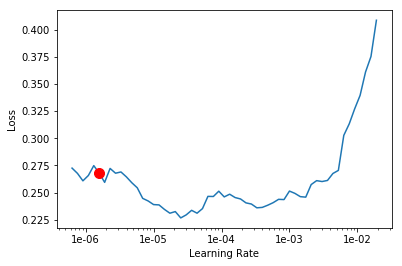

In [16]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [17]:
learn.fit_one_cycle(10, max_lr=1e-3)

epoch,train_loss,valid_loss,quadratic_kappa,time
0,0.252888,0.273078,0.906176,08:41
1,0.247949,0.342437,0.889866,08:43
2,0.253824,0.390762,0.874943,08:39
3,0.302515,0.510608,0.809100,08:40
4,0.279757,0.354113,0.888459,08:42
5,0.251273,0.290000,0.887192,08:41
6,0.221042,0.277762,0.900999,08:40
7,0.191918,0.250061,0.908595,08:40
8,0.170254,0.241846,0.920448,08:41
9,0.159525,0.240028,0.917388,08:41


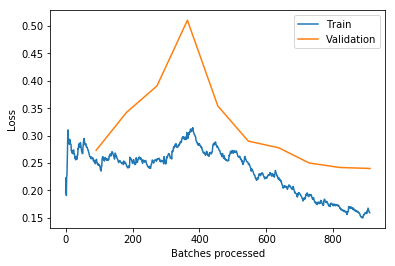

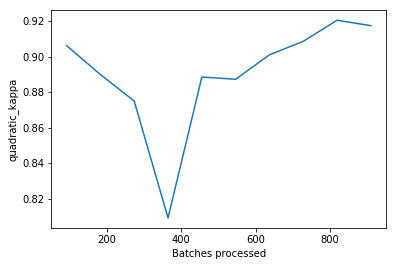

In [18]:
learn.recorder.plot_losses()
learn.recorder.plot_metrics()

In [19]:
learn.export()
learn.save('stage-2')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 2.29E-07


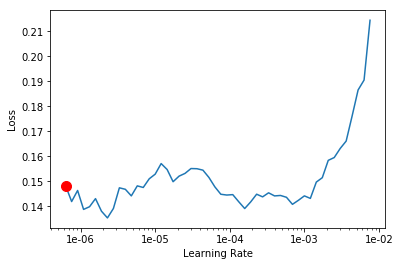

In [20]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)